# Install the Required Packages

In [1]:
!pip install torch==2.2.0 torchvision==0.17.0 matplotlib==3.7.4

# Import the Needed Libraries

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Data Preprocessing

Initialize torch manual seed to control randomness

In [20]:
torch.manual_seed(17)

### Transformation and Loading

We convert the data to tensors, normalize them and put them in batches using dataloaders

In [21]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False)

print(trainset.data.size())
print(testset.data.size())

torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])


# Initial Architecture

In [22]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


In [23]:
# Configure the model, loss function and optimizer
model = Net()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [24]:
def train(model, trainloader, loss_fn, optimizer, epoch, history):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for batch_idx, (data, target) in enumerate(trainloader):
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        total_train += target.size(0)
        correct_train += (predicted == target).sum().item()
    
    accuracy_train = 100. * correct_train / total_train
    avg_loss_train = running_loss / len(trainloader)
    
    history['train_loss'].append(avg_loss_train)
    history['train_accuracy'].append(accuracy_train)


In [25]:
def validate(model, testloader, loss_fn, history):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in testloader:
            output = model(data)
            test_loss += loss_fn(output, target).item()  
            pred = output.argmax(dim=1, keepdim=True)  
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(testloader.dataset)
    accuracy = 100. * correct / len(testloader.dataset)
    
    history['test_loss'].append(test_loss)
    history['test_accuracy'].append(accuracy)

    return test_loss, accuracy

In [26]:
# Initialize history dictionary
history = {
    'train_loss': [],
    'train_accuracy': [],
    'test_loss': [],
    'test_accuracy': []
}

In [27]:
epochs = 25
for epoch in range(1, epochs + 1):
    train(model, trainloader, loss_fn, optimizer, epoch, history)
    test_loss, test_accuracy = validate(model, testloader, loss_fn, history)
    
    print(f'Epoch {epoch} Train accuracy: {history["train_accuracy"][-1]:.4f} Val accuracy: {test_accuracy:.4f}')

Epoch 1 Train accuracy: 79.3617 Val accuracy: 95.6600
Epoch 2 Train accuracy: 91.0800 Val accuracy: 96.8300
Epoch 3 Train accuracy: 92.8933 Val accuracy: 97.5200
Epoch 4 Train accuracy: 93.8100 Val accuracy: 97.8200
Epoch 5 Train accuracy: 94.3367 Val accuracy: 98.0400
Epoch 6 Train accuracy: 94.7900 Val accuracy: 98.4200
Epoch 7 Train accuracy: 95.0983 Val accuracy: 98.4000
Epoch 8 Train accuracy: 95.3783 Val accuracy: 98.5900
Epoch 9 Train accuracy: 95.6633 Val accuracy: 98.7700
Epoch 10 Train accuracy: 95.7533 Val accuracy: 98.6500
Epoch 11 Train accuracy: 95.8667 Val accuracy: 98.7000
Epoch 12 Train accuracy: 95.9750 Val accuracy: 98.8000
Epoch 13 Train accuracy: 96.0850 Val accuracy: 98.8900
Epoch 14 Train accuracy: 96.0650 Val accuracy: 98.7400
Epoch 15 Train accuracy: 96.1300 Val accuracy: 98.8600
Epoch 16 Train accuracy: 96.2467 Val accuracy: 98.8400
Epoch 17 Train accuracy: 96.3267 Val accuracy: 98.8200
Epoch 18 Train accuracy: 96.4967 Val accuracy: 98.9300
Epoch 19 Train accu

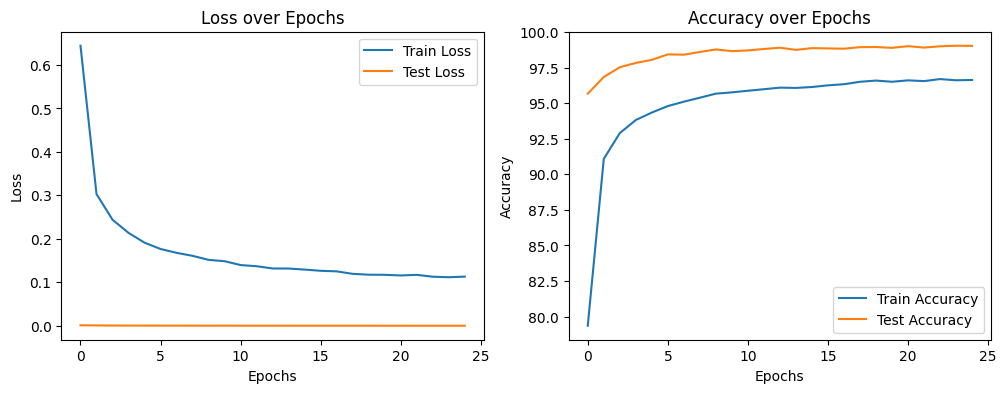

In [28]:
# Plot the training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['test_loss'], label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_accuracy'], label='Train Accuracy')
plt.plot(history['test_accuracy'], label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.show()

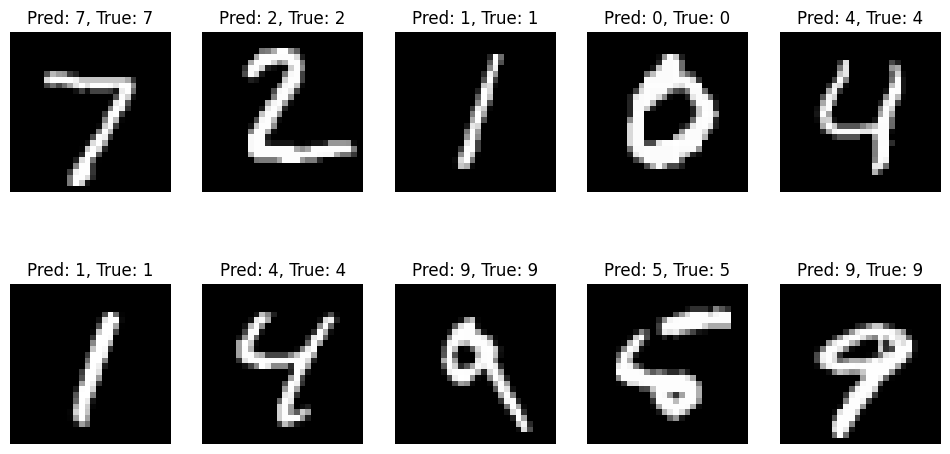

In [29]:
def visualize_predictions(model, testloader, num_images=10):
    model.eval()
    images, labels = next(iter(testloader))
    output = model(images)
    _, preds = torch.max(output, 1)

    plt.figure(figsize=(12, 6))
    for idx in range(num_images):
        ax = plt.subplot(2, 5, idx + 1)
        plt.imshow(images[idx].numpy().squeeze(), cmap='gray')
        plt.title(f'Pred: {preds[idx].item()}, True: {labels[idx].item()}')
        plt.axis('off')
    plt.show()

visualize_predictions(model, testloader)


### Conclusion for the Initial Architecture

This architecture was a good starting point and provided decent performance. However, the model showed slower convergence and a noticeable gap between training and validation accuracy initially, indicating potential underfitting early in the training process.

### Result-Driven Steps for Improvement 
- Increasing the number of filters to capture more detailed features.
- Optimizing dropout rates to prevent overfitting while maintaining high performance.

# Improved Architecture

In [30]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        self.conv2_drop = nn.Dropout2d(p=0.2)
        self.fc1 = nn.Linear(1024, 128)
        self.fc2 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(p=0.4)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 1024)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [31]:
model = Net()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Re-initialize history dictionary
history = {
    'train_loss': [],
    'train_accuracy': [],
    'test_loss': [],
    'test_accuracy': []
}

In [32]:
torch.manual_seed(17)
epochs = 25
for epoch in range(1, epochs + 1):
    train(model, trainloader, loss_fn, optimizer, epoch, history)
    test_loss, test_accuracy = validate(model, testloader, loss_fn, history)
    
    print(f'Epoch {epoch} Train accuracy: {history["train_accuracy"][-1]:.4f} Val accuracy: {test_accuracy:.4f}')

Epoch 1 Train accuracy: 93.1333 Val accuracy: 98.6000
Epoch 2 Train accuracy: 97.7217 Val accuracy: 98.8500
Epoch 3 Train accuracy: 98.2667 Val accuracy: 99.1100
Epoch 4 Train accuracy: 98.5033 Val accuracy: 99.0000
Epoch 5 Train accuracy: 98.7350 Val accuracy: 99.1600
Epoch 6 Train accuracy: 98.9383 Val accuracy: 99.1100
Epoch 7 Train accuracy: 98.9467 Val accuracy: 99.1900
Epoch 8 Train accuracy: 99.0867 Val accuracy: 99.2600
Epoch 9 Train accuracy: 99.1450 Val accuracy: 99.3000
Epoch 10 Train accuracy: 99.1983 Val accuracy: 99.3800
Epoch 11 Train accuracy: 99.2750 Val accuracy: 99.2700
Epoch 12 Train accuracy: 99.3550 Val accuracy: 99.3100
Epoch 13 Train accuracy: 99.3883 Val accuracy: 99.3300
Epoch 14 Train accuracy: 99.4167 Val accuracy: 99.3500
Epoch 15 Train accuracy: 99.3867 Val accuracy: 99.2500
Epoch 16 Train accuracy: 99.3917 Val accuracy: 99.2900
Epoch 17 Train accuracy: 99.4483 Val accuracy: 99.4100
Epoch 18 Train accuracy: 99.5067 Val accuracy: 99.3300
Epoch 19 Train accu

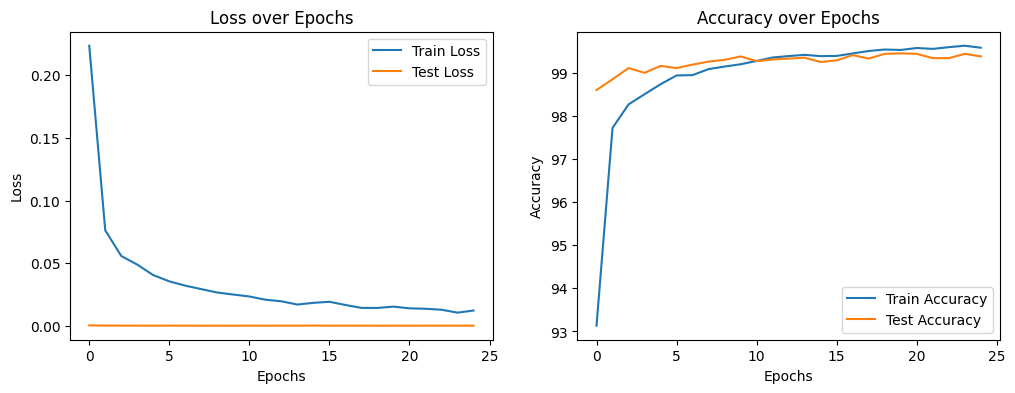

In [33]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['test_loss'], label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_accuracy'], label='Train Accuracy')
plt.plot(history['test_accuracy'], label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.show()

### Conclusion for the Improved Architecture

This architecture significantly improved performance. The higher number of filters and optimized dropout rates allowed the model to capture more detailed features and better regularize, leading to faster convergence and higher accuracy

In [35]:
torch.save(model.state_dict(), 'mnist_model.pt')